## Merging datasets and partial training

This vignette demonstrates how to merge datasets, which are present in different zarr files. The vignette will also demonstrate the steps for performing partial training. Partial PCA training is a lightweight alternative to perform batch effect correction, that often helps obtain a well-integrated embedding and clustering.

In [1]:
%load_ext autotime

import scarf
scarf.__version__

'0.18.1'

time: 3.47 s (started: 2021-09-04 13:27:24 +02:00)


---
### 1) Fetch datasets in Zarr format

Here we will use the same datasets are we use in the ['data projection'](https://scarf.readthedocs.io/en/latest/vignettes/data_projection.html) vignette. We download the files in zarr format.

In [2]:
scarf.fetch_dataset(
    dataset_name='kang_15K_pbmc_rnaseq',
    save_path='scarf_datasets',
    as_zarr=True
)

scarf.fetch_dataset(
    dataset_name='kang_14K_ifnb-pbmc_rnaseq', 
    save_path='scarf_datasets',
    as_zarr=True
)

time: 48.8 s (started: 2021-09-04 13:27:27 +02:00)


The Zarr files need to be loaded as a DataStore before they can be merged:

In [3]:
ds_ctrl = scarf.DataStore(
    'scarf_datasets/kang_15K_pbmc_rnaseq/data.zarr/',
    nthreads=4
)

ds_ctrl

DataStore has 8487 (14619) cells with 1 assays: RNA
   Cell metadata:
            'I', 'ids', 'names', 'RNA_UMAP1', 'RNA_UMAP2', 
            'RNA_leiden_cluster', 'RNA_nCounts', 'RNA_nFeatures', 'RNA_percentMito', 'RNA_percentRibo', 
            'cluster_labels'
   RNA assay has 11352 (35635) features and following metadata:
            'I', 'ids', 'names', 'I__hvgs', 'dropOuts', 
            'nCells'

time: 62 ms (started: 2021-09-04 13:28:16 +02:00)


In [4]:
ds_stim = scarf.DataStore(
    'scarf_datasets/kang_14K_ifnb-pbmc_rnaseq/data.zarr',
    nthreads=4
)

ds_stim

DataStore has 10111 (14446) cells with 1 assays: RNA
   Cell metadata:
            'I', 'ids', 'names', 'RNA_UMAP1', 'RNA_UMAP2', 
            'RNA_leiden_cluster', 'RNA_nCounts', 'RNA_nFeatures', 'RNA_percentMito', 'RNA_percentRibo', 
            'cluster_labels'
   RNA assay has 11051 (35635) features and following metadata:
            'I', 'ids', 'names', 'I__hvgs', 'dropOuts', 
            'nCells'

time: 47 ms (started: 2021-09-04 13:28:16 +02:00)


---
### 2) Merging datasets

The merging step will make sure that the features are in the same order as in the merged file. The merged data will be dumped into a new Zarr file. `ZarrMerge` class allows merging multiple samples at the same time. Though only one kind of assays can be added at a time, other modalities for the same cells can be added at a later point. 

In [5]:
#Can be used to merge multiple assays
scarf.ZarrMerge(
    # Path where merged Zarr files will be saved
    zarr_path='scarf_datasets/kang_merged_pbmc_rnaseq.zarr',  
    
    # assays to be merged
    assays=[ds_ctrl.RNA, ds_stim.RNA],
    
    # these names will be preprended to the cell ids with '__' delimiter
    names=['ctrl', 'stim'],
    
    # Name of the merged assay. `overwrite` will remove an existing Zarr file.
    merge_assay_name='RNA',
    overwrite=True
).dump()

Writing data to merged file:   0%|                                                                            …

Writing data to merged file:   0%|                                                                            …

time: 35.3 s (started: 2021-09-04 13:28:16 +02:00)


Load the merged Zarr file as a DataStore:

In [6]:
ds = scarf.DataStore(
    'scarf_datasets/kang_merged_pbmc_rnaseq.zarr',
    nthreads=4
)

(RNA) Computing nCells and dropOuts:   0%|                                                                    …

(RNA) Computing nCounts:   0%|                                                                                …

(RNA) Computing nFeatures:   0%|                                                                              …

(RNA) Computing RNA_percentMito:   0%|                                                                        …

(RNA) Computing RNA_percentRibo:   0%|                                                                        …

time: 12.4 s (started: 2021-09-04 13:28:51 +02:00)


So now we print the merged datastore. The merging removed all the precalculated data. Even the information on which cells were filtered out is lost in the process. This is done deliberately, to allow users to start fresh with the merged dataset.

In [7]:
ds

DataStore has 29065 (29065) cells with 1 assays: RNA
   Cell metadata:
            'I', 'ids', 'names', 'RNA_nCounts', 'RNA_nFeatures', 
            'RNA_percentMito', 'RNA_percentRibo', 'orig_RNA_UMAP1', 'orig_RNA_UMAP2', 'orig_RNA_leiden_cluster', 
            'orig_RNA_nCounts', 'orig_RNA_nFeatures', 'orig_RNA_percentMito', 'orig_RNA_percentRibo', 'orig_cluster_labels', 
          
   RNA assay has 12450 (35635) features and following metadata:
            'I', 'ids', 'names', 'dropOuts', 'nCells', 
          

time: 16 ms (started: 2021-09-04 13:29:04 +02:00)


If we have a look at the cell attributes table, we can clearly see the that the sample identity is shown in the `ids` column, prepended to the barcode.

In [8]:
ds.cells.head()

,I,ids,names,RNA_nCounts,RNA_nFeatures,RNA_percentMito,RNA_percentRibo,orig_RNA_UMAP1,orig_RNA_UMAP2,orig_RNA_leiden_cluster,orig_RNA_nCounts,orig_RNA_nFeatures,orig_RNA_percentMito,orig_RNA_percentRibo,orig_cluster_labels
0,True,ctrl__AAACATACAATGCC-1,AAACATACAATGCC-1,2191.0,852.0,0.273848,32.131447,2.224133,-7.265071,2,2191.0,852.0,0.273848,32.131447,CD4 naive T
1,True,ctrl__AAACATACATTTCC-1,AAACATACATTTCC-1,3018.0,878.0,0.099404,15.440689,-2.979369,14.908970,10,3018.0,878.0,0.099404,15.440689,CD 14 Mono
2,True,ctrl__AAACATACCAGAAA-1,AAACATACCAGAAA-1,2481.0,713.0,0.241838,4.957678,4.714710,9.148883,4,2481.0,713.0,0.241838,4.957678,CD 14 Mono
3,True,ctrl__AAACATACCAGCTA-1,AAACATACCAGCTA-1,3157.0,950.0,0.031676,11.308204,3.747393,13.955492,4,3157.0,950.0,0.031676,11.308204,CD 14 Mono
4,True,ctrl__AAACATACCATGCA-1,AAACATACCATGCA-1,703.0,337.0,0.426743,10.953058,NaN,NaN,-1,703.0,337.0,0.426743,10.953058,nan


time: 62 ms (started: 2021-09-04 13:29:04 +02:00)


It can be a good idea to keep track of the cells from different samples, we can fetch out the dataset id from cell-barcodes and add them separately in a new column (this step might get automated in the future).

In [9]:
ds.cells.insert(
    column_name='sample_id',
    values=[x.split('__')[0] for x in ds.cells.fetch_all('ids')],
    overwrite=True
)

time: 31 ms (started: 2021-09-04 13:29:04 +02:00)


Rather than performing a fresh round of annotation, we will also import the cluster labels from the unmerged datasets. This help us at later steps to evaluate our results.

In [10]:
ctrl_labels = list(ds_ctrl.cells.fetch_all('cluster_labels'))
stim_labels = list(ds_stim.cells.fetch_all('cluster_labels'))

ds.cells.insert(
    column_name='imported_labels',
    values=ctrl_labels + stim_labels,
    overwrite=True
)

time: 47 ms (started: 2021-09-04 13:29:04 +02:00)


As well as re-using annotations, we import the information about which cells where kept and which ones where filtered out.

In [11]:
ctrl_valid_cells = list(ds_ctrl.cells.fetch_all('I'))
stim_valid_cells = list(ds_stim.cells.fetch_all('I'))

ds.cells.update_key(
    values=ctrl_valid_cells + stim_valid_cells,
    key='I'
)

time: 15 ms (started: 2021-09-04 13:29:04 +02:00)


Now we can check the number of cells from each of the samples:

In [12]:
ds.cells.to_pandas_dataframe(
    ['sample_id'],
    key='I'
)['sample_id'].value_counts()

stim    10111
ctrl     8487
Name: sample_id, dtype: int64

time: 31 ms (started: 2021-09-04 13:29:04 +02:00)


---
### 3) Naive analysis of merged datasets

By naive, we mean that we make no attempt to remove/account for the latent factors that might contribute to batch effect or treatment-specific effect.
It is usually a good idea to perform a 'naive' pipeline to get an idea about the degree of batch effects.

We start with detecting the highly variable genes:

(RNA) Computing nCells:   0%|                                                                                 …

(RNA) Computing normed_tot:   0%|                                                                             …

(RNA) Computing sigmas:   0%|                                                                                 …

INFO: 2000 genes marked as HVGs


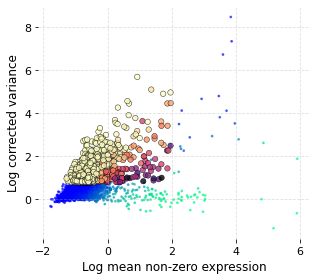

time: 15.8 s (started: 2021-09-04 13:29:04 +02:00)


In [13]:
ds.mark_hvgs(
    min_cells=10,
    top_n=2000,
    min_mean=-3, 
    max_mean=2,
    max_var=6
)

Next, we create a graph of cells in a standard way.

In [14]:
ds.make_graph(
    feat_key='hvgs',
    k=21, 
    dims=25,
    n_centroids=100
)

Normalizing with feature subset:   0%|                                                                        …

Writing data to normed__I__hvgs/data:   0%|                                                                   …

Calculating mean of norm. data:   0%|                                                                         …

Calculating std. dev. of norm. data:   0%|                                                                    …

Fitting PCA:   0%|                                                                                            …

Fitting ANN:   0%|                                                                                            …

Fitting kmeans:   0%|                                                                                         …

Estimating seed partitions:   0%|                                                                             …

Saving KNN graph:   0%|                                                                                       …

Smoothening KNN distances:   0%|                                                                              …

INFO: ANN recall: 99.77%
time: 45.9 s (started: 2021-09-04 13:29:20 +02:00)


Calculating UMAP embedding of cells:

In [15]:
ds.run_umap(
    n_epochs=250, 
    spread=5,
    min_dist=1,
    parallel=True
)

	completed  0  /  250 epochs
	completed  25  /  250 epochs
	completed  50  /  250 epochs
	completed  75  /  250 epochs
	completed  100  /  250 epochs
	completed  125  /  250 epochs
	completed  150  /  250 epochs
	completed  175  /  250 epochs
	completed  200  /  250 epochs
	completed  225  /  250 epochs
time: 11.4 s (started: 2021-09-04 13:30:06 +02:00)


In [16]:
ds.cells.head()

,I,ids,names,RNA_UMAP1,RNA_UMAP2,RNA_nCounts,RNA_nFeatures,RNA_percentMito,RNA_percentRibo,imported_labels,orig_RNA_UMAP1,orig_RNA_UMAP2,orig_RNA_leiden_cluster,orig_RNA_nCounts,orig_RNA_nFeatures,orig_RNA_percentMito,orig_RNA_percentRibo,orig_cluster_labels,sample_id
0,True,ctrl__AAACATACAATGCC-1,AAACATACAATGCC-1,0.365985,12.116079,2191.0,852.0,0.273848,32.131447,CD4 naive T,2.224133,-7.265071,2,2191.0,852.0,0.273848,32.131447,CD4 naive T,ctrl
1,True,ctrl__AAACATACATTTCC-1,AAACATACATTTCC-1,15.402155,-22.223019,3018.0,878.0,0.099404,15.440689,CD 14 Mono,-2.979369,14.908970,10,3018.0,878.0,0.099404,15.440689,CD 14 Mono,ctrl
2,True,ctrl__AAACATACCAGAAA-1,AAACATACCAGAAA-1,24.932833,-15.707145,2481.0,713.0,0.241838,4.957678,CD 14 Mono,4.714710,9.148883,4,2481.0,713.0,0.241838,4.957678,CD 14 Mono,ctrl
3,True,ctrl__AAACATACCAGCTA-1,AAACATACCAGCTA-1,21.465948,-17.935938,3157.0,950.0,0.031676,11.308204,CD 14 Mono,3.747393,13.955492,4,3157.0,950.0,0.031676,11.308204,CD 14 Mono,ctrl
4,False,ctrl__AAACATACCATGCA-1,AAACATACCATGCA-1,NaN,NaN,703.0,337.0,0.426743,10.953058,nan,NaN,NaN,-1,703.0,337.0,0.426743,10.953058,nan,ctrl


time: 94 ms (started: 2021-09-04 13:30:17 +02:00)


Visualization of cells from the two samples in the 2D UMAP space:

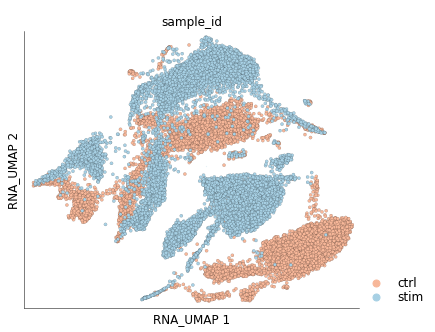

time: 438 ms (started: 2021-09-04 13:30:17 +02:00)


In [17]:
ds.plot_layout(
    layout_key='RNA_UMAP',
    color_by='sample_id',
    cmap='RdBu', 
    legend_ondata=False
)

Visualization of cluster labels in the 2D UMAP space:

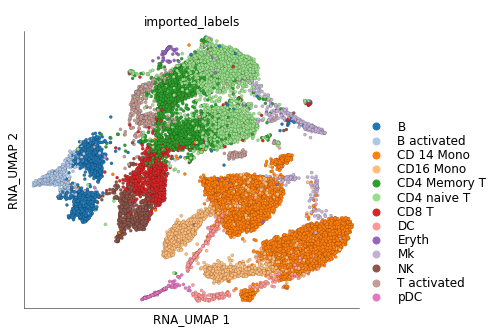

time: 625 ms (started: 2021-09-04 13:30:18 +02:00)


In [18]:
ds.plot_layout(
    layout_key='RNA_UMAP', 
    color_by='imported_labels',
    legend_ondata=False
)

---
### 4) Partial PCA training to reduce batch effects

The plots above clearly show that the cells from the two samples are distinct on the UMAP space and have not integrated. This clearly indicates a treatment-specific or simply a batch effect between the cells from the two samples. Another interesting pattern in the UMAP plot above is the 'mirror effect', i.e. the equivalent clusters from the two samples look like mirror images. This is often seen in the datasets where the heterogenity/cell population composition is not strongly affected by the treatment.

We will now attempt to integrate the cells from the two samples so that we obtain same cell types that do not form separate clusters. One can do this by training the PCA on cells from only one of the samples. Training PCA on cells from only one of the samples will diminish the contribution of genes differentially expressed between the two samples.

First, we need to create a boolean column in the cell attribute table. This column will indicate whether a cell belongs to one of the samples. Here we will create a new column `is_ctrl` and mark the values as True when a cell belongs to the `ctrl` sample.

In [19]:
ds.cells.insert(
    column_name=f'is_ctrl',
    values=(ds.cells.fetch_all('sample_id') == 'ctrl'),
    overwrite=True
)

time: 0 ns (started: 2021-09-04 13:30:18 +02:00)


The next step is to perform the partial PCA training. PCA is trained during the graph creation step. We will now use `pca_cell_key` parameter and set it to `is_ctrl` so that only 'ctrl' cells are used for PCA training.

In [20]:
ds.make_graph(
    feat_key='hvgs',
    k=21, 
    dims=25,
    n_centroids=100,
    pca_cell_key='is_ctrl'
)

INFO: Using existing normalized data with cell key I and feat key I__hvgs


Calculating mean of norm. data:   0%|                                                                         …

Calculating std. dev. of norm. data:   0%|                                                                    …

Fitting PCA:   0%|                                                                                            …

Fitting ANN:   0%|                                                                                            …

Fitting kmeans:   0%|                                                                                         …

Estimating seed partitions:   0%|                                                                             …

Saving KNN graph:   0%|                                                                                       …

Smoothening KNN distances:   0%|                                                                              …

INFO: ANN recall: 99.75%
time: 24 s (started: 2021-09-04 13:30:18 +02:00)


We run UMAP as usual, but the UMAP embeddings are saved in a new cell attribute column so as to not overwrite the previous UMAP values. The new column will be called `RNA_pUMAP`; 'RNA' is automatically prepend because the assay name is `RNA`

In [21]:
ds.run_umap(
    n_epochs=250, 
    spread=5,
    min_dist=1,
    parallel=True,
    label='pUMAP'
)

	completed  0  /  250 epochs
	completed  25  /  250 epochs
	completed  50  /  250 epochs
	completed  75  /  250 epochs
	completed  100  /  250 epochs
	completed  125  /  250 epochs
	completed  150  /  250 epochs
	completed  175  /  250 epochs
	completed  200  /  250 epochs
	completed  225  /  250 epochs
time: 12.1 s (started: 2021-09-04 13:30:42 +02:00)


Visualize the new UMAP

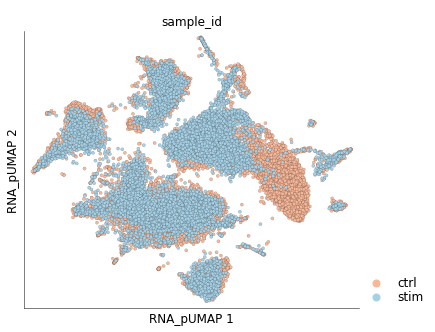

time: 485 ms (started: 2021-09-04 13:30:55 +02:00)


In [22]:
ds.plot_layout(
    layout_key='RNA_pUMAP',
    color_by='sample_id',
    cmap='RdBu',
    legend_ondata=False
)

Visualization of cluster labels in the new UMAP space shows that the cells from the same cell-type do not split into separate clusters like they did before.

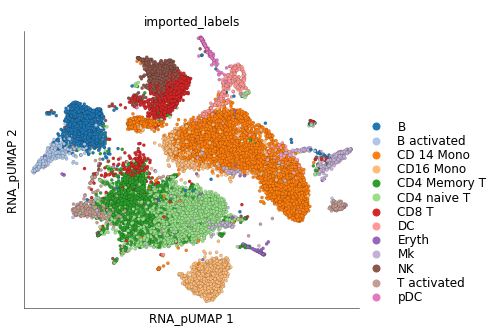

time: 672 ms (started: 2021-09-04 13:30:55 +02:00)


In [23]:
ds.plot_layout(
    layout_key='RNA_pUMAP',
    color_by='imported_labels',
    legend_ondata=False
)

---
That is all for this vignette.